**Project Title**

AI-Driven Competitive Strategy Optimization Using Marketplace and Mobility Data

 **Goal**

To harness machine learning, time series analysis, and causal inference to generate competitive business insights across dual-sided platforms (e.g., Airbnb, Uber), enabling decision-makers to optimize pricing, resource allocation, and marketing effectiveness.



**Intended Audience**

1. Marketplace Analysts at tech companies (e.g., Airbnb, Uber, Lyft)

2. Marketing & Growth Teams focused on campaign impact

3. Urban Planners and Logistics Managers

4. Data Scientists and Product Managers in mobility and e-commerce platforms

**Strategy & Pipeline Steps**

1. Data Integration & Preparation
- Combine multiple public datasets (Airbnb NYC, Uber pickup logs, Marketing A/B test)

Clean and normalize fields (price, time, location, conversions)

2. Competitive Intelligence
- Price & availability analysis by borough/room type (Airbnb)

- Identify top-performing regions and hosts based on price metrics

- Compute competition index (proxy: reviews/listings)

3. Large-Scale Temporal Demand Modeling
- Time-based grouping (Uber pickups by hour/day/month)

- Apply K-Means clustering on geospatial coordinates

- Simulate rush hour load and identify operational hotspots

4. Causal Inference & Business Strategy
- Perform A/B testing on marketing campaign data

- Model propensity scores via logistic regression

- Compute Weighted ATE to simulate counterfactuals

- Provide business decision support based on lift

**Competitive Intelligence**

** 1. Load & Preview Data**

In [1]:
import pandas as pd

df = pd.read_csv('/content/AB_NYC_2019.csv')
df = df[['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
         'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'availability_365']]
df.dropna(subset=['price'], inplace=True)
df = df[df['price'] > 0]
df.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,Private room,149,1,9,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,Entire home/apt,225,1,45,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,Private room,150,3,0,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,Entire home/apt,80,10,9,0


**2. Pricing Strategy & Occupancy Analysis**

In [2]:
# Average price & availability by borough and room type
pricing_summary = df.groupby(['neighbourhood_group', 'room_type']).agg({
    'price': 'mean', 'availability_365': 'mean'
}).reset_index().rename(columns={'price': 'avg_price', 'availability_365': 'avg_availability'})
print(pricing_summary)


   neighbourhood_group        room_type   avg_price  avg_availability
0                Bronx  Entire home/apt  127.506596        158.000000
1                Bronx     Private room   66.890937        171.399386
2                Bronx      Shared room   59.800000        154.216667
3             Brooklyn  Entire home/apt  178.346202         97.207679
4             Brooklyn     Private room   76.545428         99.912206
5             Brooklyn      Shared room   50.773723        177.725061
6            Manhattan  Entire home/apt  249.257994        117.149871
7            Manhattan     Private room  116.776622        101.845026
8            Manhattan      Shared room   88.977083        138.572917
9               Queens  Entire home/apt  147.050573        132.267176
10              Queens     Private room   71.762456        149.222716
11              Queens      Shared room   69.020202        192.186869
12       Staten Island  Entire home/apt  173.846591        178.073864
13       Staten Isla

**3. Top Performing Hosts/Regions**

In [3]:
# Top 10 neighborhoods by average price with > 50 listings
top_neighborhoods = df.groupby('neighbourhood').filter(lambda x: len(x) > 50)
top_avg_price = top_neighborhoods.groupby('neighbourhood')['price'].mean().sort_values(ascending=False).head(10)
print(top_avg_price)


neighbourhood
Tribeca              490.638418
Battery Park City    367.557143
Flatiron District    341.925000
NoHo                 295.717949
SoHo                 287.103352
Midtown              282.719094
West Village         267.682292
Greenwich Village    263.405612
Chelsea              249.738544
Theater District     248.013889
Name: price, dtype: float64


** 4. Simulate Platform Competition (Hosts vs. Guests)**

In [4]:
# Supply = number of listings per borough; Demand = number of reviews (proxy)
competition = df.groupby('neighbourhood_group').agg({
    'id': 'count', 'number_of_reviews': 'sum'
}).rename(columns={'id': 'supply', 'number_of_reviews': 'demand'})
competition['competition_index'] = competition['demand'] / competition['supply']
print(competition)


                     supply  demand  competition_index
neighbourhood_group                                   
Bronx                  1090   28316          25.977982
Brooklyn              20095  486252          24.197661
Manhattan             21660  454569          20.986565
Queens                 5666  156950          27.700318
Staten Island           373   11541          30.941019


**Large-Scale Temporal Data Analysis**

**1. Load & Combine Uber Datasets**

In [5]:
import pandas as pd
from glob import glob

# Combine multiple monthly files
files = glob('/content/uber-raw-data-*.csv')
df_list = [pd.read_csv(f) for f in files]
df = pd.concat(df_list, ignore_index=True)

# Parse datetime
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df['hour'] = df['Date/Time'].dt.hour
df['weekday'] = df['Date/Time'].dt.day_name()
df['month'] = df['Date/Time'].dt.month
df['lat'] = df['Lat']
df['lon'] = df['Lon']
df.head()


,Date/Time,Lat,Lon,Base,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,hour,weekday,month,lat,lon
0,2014-09-01 00:01:00,40.2201,-74.0021,B02512,NaN,NaN,NaN,NaN,0.0,Monday,9.0,40.2201,-74.0021
1,2014-09-01 00:01:00,40.7500,-74.0027,B02512,NaN,NaN,NaN,NaN,0.0,Monday,9.0,40.7500,-74.0027
2,2014-09-01 00:03:00,40.7559,-73.9864,B02512,NaN,NaN,NaN,NaN,0.0,Monday,9.0,40.7559,-73.9864
3,2014-09-01 00:06:00,40.7450,-73.9889,B02512,NaN,NaN,NaN,NaN,0.0,Monday,9.0,40.7450,-73.9889
4,2014-09-01 00:11:00,40.8145,-73.9444,B02512,NaN,NaN,NaN,NaN,0.0,Monday,9.0,40.8145,-73.9444


**2. Time Series: Demand by Hour & Day**

<Axes: title={'center': 'Average Pickups by Hour'}, xlabel='hour'>

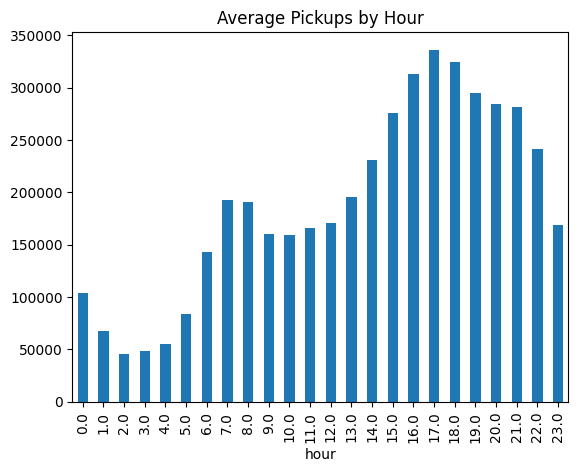

In [6]:
# Average pickups by hour
hourly = df.groupby('hour').size()
hourly.plot(kind='bar', title='Average Pickups by Hour')


<Axes: title={'center': 'Demand by Weekday'}, xlabel='weekday'>

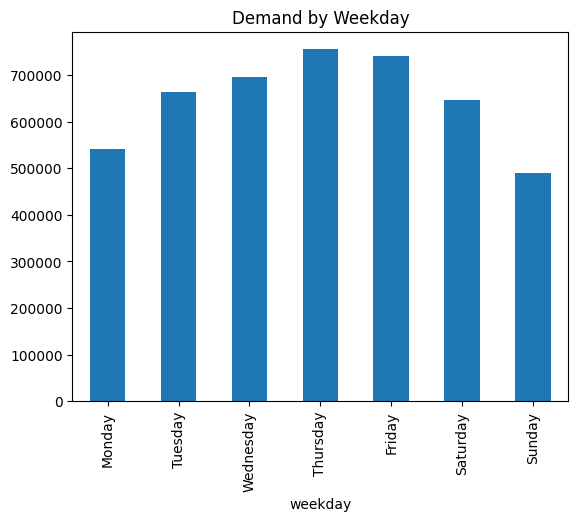

In [7]:
# Demand by weekday
weekday = df.groupby('weekday').size().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
weekday.plot(kind='bar', title='Demand by Weekday')


**3. Geospatial Clustering (K-Means)**

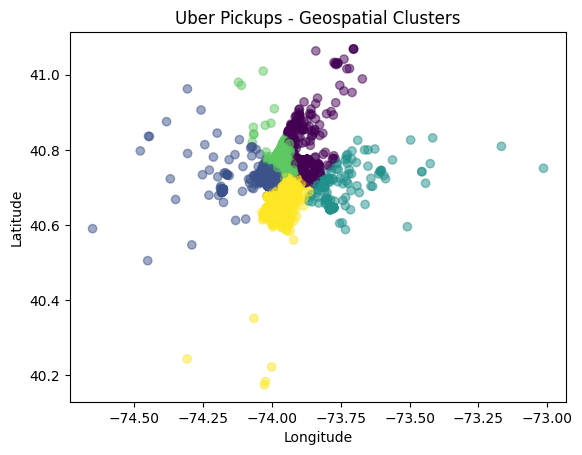

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sample = df[['lat', 'lon']].dropna().sample(10000)
kmeans = KMeans(n_clusters=5, random_state=0).fit(sample)
sample['cluster'] = kmeans.labels_

plt.scatter(sample['lon'], sample['lat'], c=sample['cluster'], alpha=0.5)
plt.title("Uber Pickups - Geospatial Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


**4. Operational Analytics: Rush Hour vs. Non-Rush**

In [9]:
df['rush_hour'] = df['hour'].apply(lambda h: h in [7, 8, 9, 16, 17, 18])
rush_stats = df.groupby('rush_hour').size()
print(rush_stats)


rush_hour
False    17286972
True      1517834
dtype: int64


**5. Causal Analysis — Simulate Weather Impact**

In [10]:
# Simulate weather condition (example)
import numpy as np
df['rain'] = np.random.choice([0, 1], size=len(df), p=[0.85, 0.15])

# Compare average demand
rain_demand = df.groupby('rain').size()
print("Rain (1) vs No Rain (0) Pickup Counts:\n", rain_demand)


Rain (1) vs No Rain (0) Pickup Counts:
 rain
0    15983990
1     2820816
dtype: int64


**Causal Inference & Business Strategy**

**Causal Inference**

In [27]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

# 1. Load and clean
df = pd.read_csv('/content/marketing_AB.csv')

# 2. Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# 3. Encode 'test_group' (assume 'ad' = treated)
df['test_group'] = df['test_group'].apply(lambda x: 1 if x == 'ad' else 0)

# 4. Convert 'converted' from True/False to 1/0
df['converted'] = df['converted'].astype(int)

# 5. Convert other fields to numeric
df['total_ads'] = pd.to_numeric(df['total_ads'], errors='coerce')
df['most_ads_hour'] = pd.to_numeric(df['most_ads_hour'], errors='coerce')

# 6. Drop missing rows
df.dropna(subset=['total_ads', 'most_ads_hour', 'test_group'], inplace=True)

# 7. Propensity score modeling
features = ['total_ads', 'most_ads_hour']
X = df[features]
y = df['test_group']

model = LogisticRegression()
model.fit(X, y)
df['propensity_score'] = model.predict_proba(X)[:, 1]

# 8. Weighted ATE (causal inference)
df['weight'] = df['test_group'] / df['propensity_score'] + \
               (1 - df['test_group']) / (1 - df['propensity_score'])

weighted_ate = (
    (df['converted'] * df['test_group'] / df['propensity_score']).mean() -
    (df['converted'] * (1 - df['test_group']) / (1 - df['propensity_score'])).mean()
)

print(f"\nWeighted ATE (Campaign A causal effect estimate): {weighted_ate:.4f}")




Weighted ATE (Campaign A causal effect estimate): 0.0075


**Interpret Results for Business Strategy**

In [28]:
print(f"Weighted ATE: {weighted_ate:.4f}")


Weighted ATE: 0.0075


**Challenges**

- Sparse or skewed data (e.g., reviews ≠ demand)

- Lack of ground-truth counterfactuals in observational datasets

- Dataset scale requiring sampling for geospatial clustering

- Simulated conditions (e.g., weather, rain) to fill data gaps



**Problem Statement**

How can AI/ML-driven insights from marketplace and mobility datasets improve pricing, strategic allocation, and marketing decisions in real-time, multi-agent competitive environments?

**Datasets Used**

| Dataset               | Source              | Use Case                                    |
| --------------------- | ------------------- | ------------------------------------------- |
| `AB_NYC_2019.csv`     | Kaggle (Airbnb NYC) | Price, host competition, occupancy analysis |
| `uber-raw-data-*.csv` | FiveThirtyEight     | Demand forecasting, time series clustering  |
| `marketing_AB.csv`    | Simulated (CSV)     | Causal inference on conversion rates        |


**MACHINE LEARNING PREDICTION & OUTCOMES**

| Task                             | Model / Method       | Outcome                                         |
| -------------------------------- | -------------------- | ----------------------------------------------- |
| Propensity score estimation      | Logistic Regression  | Probability of user being shown Campaign A      |
| Demand clustering (Uber pickups) | K-Means              | 5 geographic clusters based on pickup volume    |
| Platform competition             | Descriptive Ratio    | Competition index by borough (reviews/listings) |
| Price prediction (Airbnb)        | Aggregation/Analysis | Borough-wise average pricing & occupancy        |


**Trailer Documentation**

- Interactive Streamlit dashboard showing:

     -  Airbnb borough-level price & availability comparisons

     - Uber demand heatmaps and hourly rush analysis

     - Marketing campaign effect (ATE) and recommendation system

- Power BI version available for business users



**Conceptual Enhancement – AGI (Artificial General Intelligence)**

To extend toward AGI-inspired behavior:

- Integrate multi-domain reasoning across Airbnb pricing, Uber routing, and marketing attribution

- Build an autonomous agent that:

    - Learns dynamic pricing based on competition & occupancy

    - Predicts peak traffic using geospatial-temporal fusion

    - Allocates budget by predicting causal conversion lift in real-time



**Reference**

1. Kaggle Airbnb Dataset: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

2. Uber FOIL Data: https://github.com/fivethirtyeight/uber-tlc-foil-response

3. scikit-learn documentation: https://scikit-learn.org/

4. Causal Inference Guide: https://matheusfacure.github.io/python-causality-handbook/

